# Build an agent with LangGraph

By themselves, LLMs cannot take **actions** - they just output text. Agents are systems that use LLMs as reasoning engines to determine which actions to take and the inputs to pass them. After executing actions, the results can be fed back into the LLM to determine whether more actions are needed, or whether it is okay to finish.

In this notebook, we will build an agent in LangGraph that can:

- Answer common questions by searching the web
- Maintain conversation state across calls
- Route complex queries to a human for review
- Use custom state to control its behavior
- Rewind and explore alternative conversation paths

We'll start with a basic chatbot and progressively add more sophisticated capabilities, introducing key LangGraph concepts along the way.

> The code in this notebook is adapted from [Introduction to LangGraph](https://langchain-ai.github.io/langgraph/tutorials/introduction/).


## Setup

Before we begin, please make sure you have setup the `.env` file in the project 
directory as described in [`README.md`](README.md).

Next, we will load in the necessary environment variables for this notebook:

In [1]:
import os
from dotenv import load_dotenv

_ = load_dotenv()

assert os.environ.get("GOOGLE_API_KEY")
assert os.environ.get("TAVILY_API_KEY")

## Part 1: Build a Basic Chatbot

We'll first create a simple chatbot using LangGraph. This chatbot will respond directly to user messages. Though simple, it will illustrate the core concepts of building with LangGraph. By the end of this section, we will have a built rudimentary chatbot.

Start by creating a `StateGraph`. A `StateGraph` object defines the structure of our chatbot as a "state machine". We'll add `nodes` to represent the llm and functions our chatbot can call and `edges` to specify how the bot should transition between these functions.

In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

**Notice** that we've defined our `State` as a TypedDict with a single key: `messages`. The `messages` key is annotated with the [`add_messages`](https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages) function, which tells LangGraph to append new messages to the existing list, rather than overwriting it.

So now our graph knows two things:

1. Every `node` we define will receive the current `State` as input and return a value that updates that state.
2. `messages` will be _appended_ to the current list, rather than directly overwritten. This is communicated via the prebuilt [`add_messages`](https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages) function in the `Annotated` syntax.

Next, add a "`chatbot`" node. Nodes represent units of work. They are typically regular Python functions.

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

**Notice** how the `chatbot` node function takes the current `State` as input and returns an updated `messages` list. This is the basic pattern for all LangGraph node functions.

The `add_messages` function in our `State` will append the llm's response messages to whatever messages are already in the state.

Next, add an `entry` point. This tells our graph **where to start its work** each time we run it.

In [4]:
graph_builder.set_entry_point("chatbot")

Similarly, set a `finish` point. This instructs the graph **"any time this node is run, you can exit."**

In [5]:
graph_builder.set_finish_point("chatbot")

Finally, we'll want to be able to run our graph. To do so, call "`compile()`" on the graph builder. This creates a "`CompiledGraph`" we can use invoke on our state.

In [6]:
graph = graph_builder.compile()

You can visualize the graph using the `get_graph` method and one of the "draw" methods, like `draw_ascii` or `draw_png`. The `draw` methods each require additional dependencies.

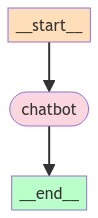

In [7]:
from IPython.display import Image, display

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

Now let's run the chatbot! 

**Tip:** You can exit the chat loop at any time by typing "quit", "exit", or "q".

In [8]:
while True:    
    
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
        
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

User:  What is the weather in Kuala Lumpur?


Assistant: I do not have access to real-time information, including weather. To get the current weather in Kuala Lumpur, I recommend checking a reliable weather website or app. 

Here are some popular options:

* **AccuWeather:** [https://www.accuweather.com/](https://www.accuweather.com/)
* **The Weather Channel:** [https://weather.com/](https://weather.com/)
* **Weather Underground:** [https://www.wunderground.com/](https://www.wunderground.com/)
* **Google Weather:** [https://www.google.com/search?q=weather+kuala+lumpur](https://www.google.com/search?q=weather+kuala+lumpur) 



User:  exit


Goodbye!


**Congratulations!** We've built our first chatbot using LangGraph. This bot can engage in basic conversation by taking user input and generating responses using an LLM.

However, the bot's knowledge is limited to what's in its training data. In the next part, we'll add a web search tool to expand the chatbot's knowledge and make it more capable.

## Part 2: Enhancing the Chatbot with Tools

To handle queries our chatbot can't answer "from memory", we'll integrate a web search tool [Tavily Search API](https://tavily.com/). Our chatbot can use this tool to find relevant information and provide better responses.

See also: [LangChain tools - Tavily Search](https://python.langchain.com/v0.2/docs/integrations/tools/tavily_search/)

In [4]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(max_results=2)
web_search_tool.invoke("What are some interesting things to do in Malaysia?")

[{'url': 'https://www.thecrazytourist.com/top-25-things-to-do-in-malaysia/',
  'content': 'Malacca also has a high concentration of museums, galleries, and places of historic interest for visitors to explore. 6. Meander around Penang. Source: ez tokboi / shutterstock. Penang Island. Penang is an island off the west coast of Malaysia that has Georgetown as its capital, named after British king, King George.'},
 {'url': 'https://www.lonelyplanet.com/articles/top-things-to-do-in-malaysia',
  'content': "Sep 1, 2023 • 8 min read\nOct 5, 2022 • 6 min read\nOct 15, 2020 • 3 min read\nJan 21, 2020 • 4 min read\nAug 8, 2019 • 5 min read\nAug 28, 2018 • 6 min read\nJul 11, 2017 • 6 min read\nMay 5, 2017 • 5 min read\nApr 17, 2015 • 6 min read\nFor Explorers Everywhere\nFollow us\nbecome a member\nJoin the Lonely Planet community of travelers\nTop destinations\nTravel Interests\nShop\nAbout Us\n© 2024 Lonely Planet, a Red Ventures company. 15 of the best things to do in Malaysia\nJan 22, 2024 • 

The results are page summaries our chat bot can use to answer questions.

Next, we'll start defining our graph. The following is all **the same as in Part 1**, except we have added `bind_tools` on our LLM. This lets the LLM know the correct JSON format to use if it wants to use our search engine.

In [5]:
from typing import Annotated

from langchain_google_genai import ChatGoogleGenerativeAI
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools([
    web_search_tool
])


def chatbot(state: State):
    return {
        "messages": [
            llm_with_tools.invoke(state["messages"])
        ]
    }


graph_builder.add_node("chatbot", chatbot)

Next we need to create a function to actually run the tools if they are called. We'll do this by adding the tools to a new node.

Below, implement a `BasicToolNode` class that checks the most recent message in the state and calls tools if the message contains `tool_calls`. It relies on the LLM's `tool_calling` support, which is available in Anthropic, OpenAI, Google Gemini, and a number of other LLM providers.

Later, we will replace this with LangGraph's prebuilt [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode) to speed things up, but building it ourselves first is helpful to see what is going on under the hood.

In [6]:
import json
from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):        
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
            
        outputs = []
        
        for tool_call in message.tool_calls:
            tool_name = tool_call["name"]
            tool = self.tools_by_name[tool_name]
            tool_args = tool_call["args"]
            tool_result = tool.invoke(tool_args)
                        
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_name,
                    tool_call_id=tool_call["id"],
                )
            )
            
        return {"messages": outputs}


In [7]:
tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

With the tool node added, we can define the `conditional_edges`. 

Recall that **edges** route the control flow from one node to the next. **Conditional edges** usually contain "if" statements to route to different nodes depending on the current graph state. These functions receive the current graph `state` and return a string or list of strings indicating which node(s) to call next.

Below, call define a router function called `route_tools`, that checks for tool_calls in the chatbot's output. Provide this function to the graph by calling `add_conditional_edges`, which tells the graph that whenever the `chatbot` node completes to check this function to see where to go next. 

The condition will route to `tools` if tool calls are present and "`__end__`" if not.

Later, we will replace this with the prebuilt [tools_condition](https://langchain-ai.github.io/langgraph/reference/prebuilt/#tools_condition) to be more concise, but implementing it ourselves first makes things more clear. 

In [10]:
from typing import Literal


def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
        
    if (hasattr(ai_message, "tool_calls") and 
        len(ai_message.tool_calls) > 0):        
        return "tools"        
    return "__end__"


In [ ]:
# The `route_tools` function returns "tools" if the chatbot asks to use a tool, and "__end__" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    
    # The following dictionary lets you tell the graph to interpret 
    # the condition's outputs as a specific node.
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {
        "tools": "tools", 
        "__end__": "__end__"
    },
)

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

In [12]:
graph = graph_builder.compile()

**Notice** that conditional edges start from a single node. This tells the graph "any time the '`chatbot`' node runs, either go to 'tools' if it calls a tool, or end the loop if it responds directly. 

Like the prebuilt `tools_condition`, our function returns the "`__end__`" string if no tool calls are made. When the graph transitions to `__end__`, it has no more tasks to complete and ceases execution. Because the condition can return `__end__`, we don't need to explicitly set a `finish_point` this time. Our graph already has a way to finish!

Let's visualize the graph we've built.

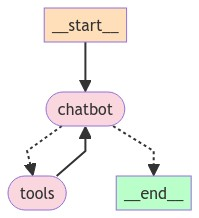

In [13]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

Now we can ask the bot questions outside its training data.

In [14]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
        
    for event in graph.stream(
        {
            "messages": [("user", user_input)]
        }
    ):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

User:  What are some interesting things to do in Malaysia?


Assistant: 
Assistant: [{"url": "https://www.thecrazytourist.com/top-25-things-to-do-in-malaysia/", "content": "Malacca also has a high concentration of museums, galleries, and places of historic interest for visitors to explore. 6. Meander around Penang. Source: ez tokboi / shutterstock. Penang Island. Penang is an island off the west coast of Malaysia that has Georgetown as its capital, named after British king, King George."}, {"url": "https://www.lonelyplanet.com/articles/top-things-to-do-in-malaysia", "content": "Sep 1, 2023 \u2022 8 min read\nOct 5, 2022 \u2022 6 min read\nOct 15, 2020 \u2022 3 min read\nJan 21, 2020 \u2022 4 min read\nAug 8, 2019 \u2022 5 min read\nAug 28, 2018 \u2022 6 min read\nJul 11, 2017 \u2022 6 min read\nMay 5, 2017 \u2022 5 min read\nApr 17, 2015 \u2022 6 min read\nFor Explorers Everywhere\nFollow us\nbecome a member\nJoin the Lonely Planet community of travelers\nTop destinations\nTravel Interests\nShop\nAbout Us\n\u00a9 2024 Lonely Planet, a Red Ventur

User:  Hi. My name is Ken.


Assistant: Nice to meet you, Ken! How can I help you today? 



User:  What is my name?


Assistant: I do not have access to personal information about you, including your name. 



User:  exit


Goodbye!


**Congrats!** We've created a conversational agent in LangGraph that can use a search engine to retrieve updated information when needed. Now it can handle a wider range of user queries.

Our chatbot still can't remember past interactions on its own, limiting its ability to have coherent, multi-turn conversations. In the next part, we'll add **memory** to address this.

The full code for the graph we've created in this section is reproduced below, replacing our `BasicToolNode` for the prebuilt [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode), and our `route_tools` condition with the prebuilt [tools_condition](https://langchain-ai.github.io/langgraph/reference/prebuilt/#tools_condition)

In [22]:
from typing import Annotated

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

graph = graph_builder.compile()

## Part 3: Adding Memory to the Chatbot

Our chatbot can now use tools to answer user questions, but it doesn't remember the context of previous interactions. This limits its ability to have coherent, multi-turn conversations.

LangGraph solves this problem through **persistent checkpointing**. If you provide a `checkpointer` when compiling the graph and a `thread_id` when calling your graph, LangGraph automatically saves the state after each step. When you invoke the graph again using the same `thread_id`, the graph loads its saved state, allowing the chatbot to pick up where it left off. 

To get started, create a `SqliteSaver` checkpointer:

In [23]:
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

**Notice** that we've specified `:memory` as the Sqlite DB path. This is convenient for our notebook (it saves it all in-memory). In a production application, you would likely change this to connect to your own DB and/or use one of the other checkpointer classes.

Next define the graph. Now that you've already built your own `BasicToolNode`, we'll replace it with LangGraph's prebuilt `ToolNode` and `tools_condition`, since these do some nice things like parallel API execution. Apart from that, the following is all copied from Part 2.

In [24]:
from typing import Annotated

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

Finally, compile the graph with the provided checkpointer.

In [25]:
graph = graph_builder.compile(checkpointer=memory)

Notice the graph hasn't changed since Part 2. All we are doing is checkpointing the `State` as the graph works through each node.

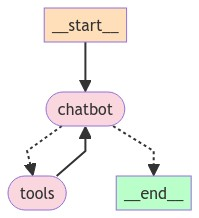

In [27]:
from IPython.display import Image, display

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

Now we can interact with our bot! First, pick a thread to use as the key for this conversation.

In [28]:
config = {"configurable": {"thread_id": "1"}}

Next, call our chat bot.

In [29]:
user_input = "Hi there! My name is Ken."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    input={
        "messages": [("user", user_input)]
    }, 
    config=config, 
    stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Ken.
================================== Ai Message ==================================

Hi Ken, nice to meet you! 👋  What can I do for you today?


**Note:** The config was provided as the **second positional argument** when calling our graph. It importantly is _not_ nested within the graph inputs (`{'messages': []}`).

Let's ask a followup: see if it remembers your name.

In [30]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    input = {
        "messages": [("user", user_input)]
    }, 
    config=config, 
    stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I will try my best to remember your name, Ken! 😊  Is there anything else I can help you with?


**Notice** that we aren't using an external list for memory – it's all handled by the checkpointer!

Try using a different `thread_id` in the `config` argument and see if it remembers your name:

In [31]:
events = graph.stream(
    input={
        "messages": [("user", user_input)]
    },
    config={
        "configurable": {
            # Only difference is we change the `thread_id` 
            # to "2" instead of "1"
            "thread_id": "2"
        }
    },
    stream_mode="values",
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I am sorry, I do not have memory of past conversations. If you would like to tell me your name, I can remember it for this conversation. What is your name?


**Notice** that the **only** change we've made is to modify the `thread_id` in the config.

By now, we have made a few checkpoints across two different threads. But what goes into a checkpoint? To inspect a graph's `state` for a given config at any time, call `get_state(config)`.

In [32]:
snapshot = graph.get_state(config) # config for thread_id = 1
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Ken.', id='efa2a6d6-d140-48d6-9604-b42d6adc0df2'), AIMessage(content='Hi Ken, nice to meet you! 👋  What can I do for you today? \n', response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-bad3872b-e569-41b6-a2fa-92b9b2131f92-0', usage_metadata={'input_tokens': 82, 'output_tokens': 18, 'total_tokens': 100}), HumanMessage(content='Remember my name?', id='ed4c40a7-4bb1-40e2-8fc5-853822f17005'), AIMessage(content='I will try my best to remember your name, Ken! 😊  Is ther

In [34]:
# Since the graph ended this turn, `next` is empty. 
# If you fetch a state from within a graph invocation, 
# next tells which node will execute next.
snapshot.next

()

The snapshot above contains the current state values, corresponding config, and the `next` node to process. In our case, the graph has reached an `__end__` state, so `next` is empty.

**Congratulations!** Our chatbot can now maintain conversation state across sessions thanks to LangGraph's checkpointing system. This opens up exciting possibilities for more natural, contextual interactions. LangGraph's checkpointing even handles **arbitrarily complex graph states**, which is much more expressive and powerful than simple chat memory.

In the next part, we'll introduce human oversight to our bot to handle situations where it may need guidance or verification before proceeding.

## Part 4: Human-in-the-loop

Agents can be unreliable and may need human input to successfully accomplish tasks. Similarly, for some actions, you may want to require human approval before executing to ensure that everything is working as intended.

LangGraph supports `human-in-the-loop` workflows in a number of ways. In this section, we will use LangGraph's `interrupt_before` functionality to always break at the tool node.

First, start from our existing code. The following is copied from Part 3.

In [17]:
from typing import Annotated

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(
    state_schema=State
)

web_search_tool = TavilySearchResults(
    max_results=2
)

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash"
)
llm_with_tools = llm.bind_tools([
    web_search_tool
])


def chatbot(state: State):
    return {
        "messages": [
            llm_with_tools.invoke(
                state["messages"]
            )
        ]
    }


graph_builder.add_node(
    node="chatbot", 
    action=chatbot
)

tool_node = ToolNode(tools=[
    web_search_tool
])
graph_builder.add_node(
    node="tools", 
    action=tool_node
)

graph_builder.add_conditional_edges(
    source="chatbot",
    path=tools_condition,
)
graph_builder.add_edge(
    start_key="tools", 
    end_key="chatbot"
)
graph_builder.set_entry_point("chatbot")

Now, compile the graph, specifying to `interrupt_before` the `action` node.

In [18]:
memory = SqliteSaver.from_conn_string(":memory:")

graph = graph_builder.compile(
    checkpointer=memory,    
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt __after__ actions, if desired.
    # interrupt_after=["tools"]
)

In [19]:
user_input = "What are some interesting things to do in Malaysia?"
config = {
    "configurable": {"thread_id": "1"}
}

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    input={
        "messages": [("user", user_input)]
    }, 
    config=config, 
    stream_mode="values"
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

What are some interesting things to do in Malaysia?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (8f80a6e0-8d95-48a9-ac92-ce7b94113dc2)
 Call ID: 8f80a6e0-8d95-48a9-ac92-ce7b94113dc2
  Args:
    query: interesting things to do in malaysia


Let's inspect the graph state to confirm it worked.

In [20]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

**Notice** the `next` node is set to **`tools`**. We've interrupted it **before** the `tools` node! Let's check the tool invocation.

In [21]:
existing_message = snapshot.values["messages"][-1]
existing_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'interesting things to do in malaysia'},
  'id': '8f80a6e0-8d95-48a9-ac92-ce7b94113dc2'}]

This query seems reasonable. Nothing to filter here. The simplest thing the human can do is just let the graph continue executing. Let's do that below.

Next, continue the graph! Passing in `None` will just let the graph continue where it left off, without adding anything new to the state.

In [22]:
# `None` will append nothing new to the current state, letting it 
# resume as if it had never been interrupted.
events = graph.stream(
    input=None, 
    config=config, 
    stream_mode="values"
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.thecrazytourist.com/top-25-things-to-do-in-malaysia/", "content": "Malacca also has a high concentration of museums, galleries, and places of historic interest for visitors to explore. 6. Meander around Penang. Source: ez tokboi / shutterstock. Penang Island. Penang is an island off the west coast of Malaysia that has Georgetown as its capital, named after British king, King George."}, {"url": "https://www.lonelyplanet.com/articles/top-things-to-do-in-malaysia", "content": "Sep 1, 2023 \u2022 8 min read\nOct 5, 2022 \u2022 6 min read\nOct 15, 2020 \u2022 3 min read\nJan 21, 2020 \u2022 4 min read\nAug 8, 2019 \u2022 5 min read\nAug 28, 2018 \u2022 6 min read\nJul 11, 2017 \u2022 6 min read\nMay 5, 2017 \u2022 5 min read\nApr 17, 2015 \u2022 6 min read\nFor Explorers Everywhere\nFollow us\nbecome a member\nJoin the Lonely Planet community of travelers\

**Congrats!** We've used an `interrupt` to add human-in-the-loop execution to your chatbot, allowing for human oversight and intervention when needed. This opens up the potential UIs you can create with your AI systems. Since we have already added a **checkpointer**, the graph can be paused **indefinitely** and resumed at any time as if nothing had happened.

Next, we'll explore how to further customize the bot's behavior using custom state updates.

Below is a copy of the code you used in this section. The only difference between this and the previous parts is the addition of the `interrupt_before` argument.

## Part 5: Manually Updating the State

In the previous section, we showed how to interrupt a graph so that a human could inspect its actions. This lets the human `read` the state, but if they want to change they agent's course, they'll need to have `write` access.

Thankfully, LangGraph lets us **manually update state**! Updating the state lets you control the agent's trajectory by modifying its actions (even modifying the past!). This capability is particularly useful when you want to correct the agent's mistakes, explore alternative paths, or guide the agent towards a specific goal.

We'll show how to update a checkpointed state below. As before, first, define your graph. We'll reuse the exact same graph as before.

In [4]:
from typing import Annotated

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(state_schema=State)


tool = TavilySearchResults(max_results=2)
tools = [tool]

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {
        "messages": [
            llm_with_tools.invoke(state["messages"])
        ]
    }


graph_builder.add_node(
    node="chatbot", 
    action=chatbot
)

tool_node = ToolNode(tools=tools)
graph_builder.add_node(
    node="tools", 
    action=tool_node
)

graph_builder.add_conditional_edges(
    source="chatbot",
    path=tools_condition,
)
graph_builder.add_edge(
    start_key="tools", 
    end_key="chatbot"
)
graph_builder.set_entry_point(key="chatbot")

memory = SqliteSaver.from_conn_string(":memory:")
graph = graph_builder.compile(
    checkpointer=memory,
    
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt __after__ actions, if desired.
    # interrupt_after=["tools"]
)

In [5]:
user_input = "What is the weather like in Kuala Lumpur?"
config = {
    "configurable": {"thread_id": "1"}
}

events = graph.stream(
    input={
        "messages": [("user", user_input)]
    }, 
    config=config
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

In [6]:
snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
existing_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (68065c86-c85e-4659-a6fc-97510889d89e)
 Call ID: 68065c86-c85e-4659-a6fc-97510889d89e
  Args:
    query: weather in Kuala Lumpur


So far, all of this is an _exact repeat_ of the previous section. The LLM just requested to use the search engine tool and our graph was interrupted. If we proceed as before, the tool will be called to search the web.

But what if the user wants to intercede? What if we think the chat bot doesn't need to use the tool? 

Let's directly provide the correct response!

In [8]:
from pprint import pprint
from langchain_core.messages import AIMessage, ToolMessage

answer = "Kuala Lumpur's weather is beautiful, sunny and warm."

new_messages = [
    # The LLM API expects some ToolMessage to match its tool call. 
    # We'll satisfy that here.
    ToolMessage(
        content=answer, 
        # LLM only has 1 tool available.
        tool_call_id=existing_message.tool_calls[0]["id"]
    ),
    
    # And then directly "put words in the LLM's mouth" by 
    # populating its response.
    AIMessage(content=answer),
]

new_messages[-1].pretty_print()

graph.update_state(
    # Which state to update
    config=config,
    
    # The updated values to provide. The "messages" in our `State` 
    # are "append-only", meaning this will be appended
    # to the existing state. We will review how to update 
    # existing messages in the next section!
    values={
        "messages": new_messages},
)

print("\n\nLast 2 messages:")
pprint(graph.get_state(config).values["messages"][-2:])

================================== Ai Message ==================================

Kuala Lumpur's weather is beautiful, sunny and warm.


Last 2 messages:
[ToolMessage(content="Kuala Lumpur's weather is beautiful, sunny and warm.", id='1f08c078-4185-4a56-aa7e-b955f6281916', tool_call_id='68065c86-c85e-4659-a6fc-97510889d89e'),
 AIMessage(content="Kuala Lumpur's weather is beautiful, sunny and warm.", id='c314c993-66a9-4257-9992-a1c5e730b85b')]


Now the graph is complete, since we've provided the final response message!

**Notice** that our new messages are _appended_ to the messages already in the state. Remember how we defined the `State` type?

```python
class State(TypedDict):
    messages: Annotated[list, add_messages]
```

We annotated `messages` with the pre-built `add_messages` function. This instructs the graph to always append values to the existing list, rather than overwriting the list directly. The same logic is applied here, so the messages we passed to `update_state` were appended in the same way!

The `update_state` function operates as if it were one of the nodes in your graph! By default, the update operation uses the node that was **last** executed, but you can manually specify it below. Let's add an update and tell the graph to treat it as if it came from the `"chatbot"` node.

In [9]:
graph.update_state(
    config=config,
    values={
        "messages": [
            AIMessage(content="I'm an AI expert!")
        ]
    },
    
    # Which node for this function to act as. It will 
    # automatically continue processing as if this node 
    # just ran.
    as_node="chatbot",
)

{'configurable': {'thread_id': '1',
  'thread_ts': '1ef336e7-361e-63fa-8003-1f9a7687fdf2'}}

Check out the [LangSmith trace](https://smith.langchain.com/public/ce83989f-6e49-4bdd-bcd5-f54ca55c8d00/r/30b1406a-ae5b-4e9e-9fe5-032be6efb92e) for this update call at the provided link. **Notice** from the trace that the graph continues into the `tools_condition` edge. We just told the graph to treat the update `as_node="chatbot"`. If we follow the diagram below and start from the `chatbot` node, we naturally end up in the `tools_condition` edge and then `__end__` since our updated message lacks tool calls.

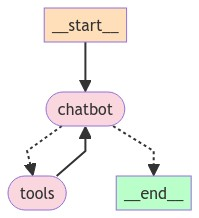

In [10]:
from IPython.display import Image, display

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

Inspect the current state as before to confirm the checkpoint reflects our manual updates.

In [11]:
snapshot = graph.get_state(config)

pprint(
    # Last 3 messages.
    snapshot.values["messages"][-3:]
)

[ToolMessage(content="Kuala Lumpur's weather is beautiful, sunny and warm.", id='1f08c078-4185-4a56-aa7e-b955f6281916', tool_call_id='68065c86-c85e-4659-a6fc-97510889d89e'),
 AIMessage(content="Kuala Lumpur's weather is beautiful, sunny and warm.", id='c314c993-66a9-4257-9992-a1c5e730b85b'),
 AIMessage(content="I'm an AI expert!", id='0e3527d4-b102-4ee2-8cdd-c67276f73752')]


In [12]:
# Since the graph ended this turn, `next` is empty. 
# If you fetch a state from within a graph invocation, 
# next tells which node will execute next.
print(snapshot.next)

()


**Notice**: that we've continued to add AI messages to the state. Since we are acting as the `chatbot` and responding with an `AIMessage` that doesn't contain `tool_calls`, the graph knows that it has entered a finished state (`next` is empty).

#### What if you want to **overwrite** existing messages? 

The [`add_messages`](https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages) function we used to annotate our graph's `State` above controls how updates are made to the `messages` key. This function looks at any message IDs in the new `messages` list. If the ID matches a message in the existing state, [`add_messages`](https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages) **overwrites** the existing message with the new content. 

As an example, let's update the tool invocation to make sure we get good results from our search engine! First, start a new thread:

In [13]:
user_input = "What is the weather like in Kuala Lumpur?"
config = {
    # we'll use thread_id = 2 here
    "configurable": {"thread_id": "2"}
}  

events = graph.stream(
    input={
        "messages": [("user", user_input)]
    }, 
    config=config, 
    stream_mode="values"
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the weather like in Kuala Lumpur?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (9b3711af-b872-4339-9dd8-fbff1c013b1c)
 Call ID: 9b3711af-b872-4339-9dd8-fbff1c013b1c
  Args:
    query: weather in Kuala Lumpur


**Next,** let's update the tool invocation for our agent. Maybe we want to search for what the weather is like in **New York** instead.

In [14]:
from langchain_core.messages import AIMessage
from pprint import pprint

snapshot = graph.get_state(config)

existing_message = snapshot.values["messages"][-1]
print("--- Original ---")
print("Message ID = ", existing_message.id)
pprint(existing_message.tool_calls[0])

new_tool_call = existing_message.tool_calls[0].copy()
new_tool_call["args"]["query"] = "weather in New York"
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[new_tool_call],
    
    # Important! The ID is how LangGraph knows to REPLACE 
    # the message in the state rather than APPEND this messages
    id=existing_message.id,
)

print("--- Updated ---")
print("Message ID = ", new_message.id)
pprint(new_message.tool_calls[0])

graph.update_state(
    config=config, 
    values={
        "messages": [new_message]
    }
)

print("\n\n--- Tool calls ---")
pprint(
    graph.get_state(config).values["messages"][-1].tool_calls
)

--- Original ---
Message ID =  run-37e31060-80ef-499a-9cfa-29a6f9af968c-0
{'args': {'query': 'weather in Kuala Lumpur'},
 'id': '9b3711af-b872-4339-9dd8-fbff1c013b1c',
 'name': 'tavily_search_results_json'}
--- Updated ---
Message ID =  run-37e31060-80ef-499a-9cfa-29a6f9af968c-0
{'args': {'query': 'weather in New York'},
 'id': '9b3711af-b872-4339-9dd8-fbff1c013b1c',
 'name': 'tavily_search_results_json'}


--- Tool calls ---
[{'args': {'query': 'weather in New York'},
  'id': '9b3711af-b872-4339-9dd8-fbff1c013b1c',
  'name': 'tavily_search_results_json'}]


Notice that we've modified the AI's tool invocation to search for "weather in **New York**" instead of "weather in **Kuala Lumpur**".

Resume the graph by streaming with an input of `None` and the existing config.

In [15]:
events = graph.stream(
    input=None, 
    config=config, 
    stream_mode="values"
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'New York', 'region': 'New York', 'country': 'United States of America', 'lat': 40.71, 'lon': -74.01, 'tz_id': 'America/New_York', 'localtime_epoch': 1719373584, 'localtime': '2024-06-25 23:46'}, 'current': {'last_updated_epoch': 1719372600, 'last_updated': '2024-06-25 23:30', 'temp_c': 26.1, 'temp_f': 79.0, 'is_day': 0, 'condition': {'text': 'Clear', 'icon': '//cdn.weatherapi.com/weather/64x64/night/113.png', 'code': 1000}, 'wind_mph': 2.2, 'wind_kph': 3.6, 'wind_degree': 203, 'wind_dir': 'SSW', 'pressure_mb': 1012.0, 'pressure_in': 29.89, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 39, 'cloud': 0, 'feelslike_c': 26.3, 'feelslike_f': 79.4, 'windchill_c': 26.0, 'windchill_f': 78.9, 'heatindex_c': 26.3, 'heatindex_f': 79.3, 'dewpoint_c': 12.1, 'dewpoint_f': 53.8, 'vis_km': 16.0, 'vis_miles': 9.0, 

**Notice** that now the graph queries the search engine using our updated query term - we were able to manually override the LLM's search here! Also note that the chatbot will not be able to answer our initial query of _"What is the weather like in **Kuala Lumpur**?"_, given the unrelated context of **New York** city's weather details.

All of this is reflected in the graph's checkpointed memory, meaning if we continue the conversation, it will recall all the _modified_ state.

In [16]:
events = graph.stream(
    input={
        "messages": (
            "user",
            "Remind me, which place was I searching the weather for?",
        )
    },
    config=config,
    stream_mode="values",
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Remind me, which place was I searching the weather for?
================================== Ai Message ==================================

You were searching for the weather in Kuala Lumpur.


**Congratulations!** We've used `interrupt_before` and `update_state` to manually modify the state as a part of a human-in-the-loop workflow. Interruptions and state modifications let us control how the agent behaves. Combined with persistent checkpointing, it means we can `pause` an action and `resume` at any point. The user doesn't have to be available when the graph interrupts!

The graph code for this section is identical to previous ones. The key snippets to remember are to add `.compile(..., interrupt_before=[...])` (or `interrupt_after`) if you want to explicitly pause the graph whenever it reaches a node. Then you can use `update_state` to modify the checkpoint and control how the graph should proceed.

## Part 6: Customizing State

So far, we've relied on a simple state (it's just a list of messages!). You can go far with this simple state, but if you want to define complex behavior without relying on the message list, you can add additional fields to the state. In this section, we will extend our chatbot with a new node to illustrate this.

In the examples above, we involved a human deterministically: the graph __always__ interrupted whenever a tool was invoked. Suppose we wanted our chatbot to have the choice of relying on a human.

One way to do this is to create a passthrough "human" node, before which the graph will always stop. We will only execute this node if the LLM invokes a "human" tool. For our convenience, we will include an `ask_human` flag in our graph state that we will flip if the LLM calls this tool.

Below, define this new graph, with an updated `State`:

In [17]:
from typing import Annotated

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]        
    ask_human: bool # This flag is new

Next, define a schema to show the model to let it decide to request assistance.

In [18]:
from langchain_core.pydantic_v1 import BaseModel


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. 
    Use this if you are unable to assist directly or if 
    the user requires support beyond your permissions.

    To use this function, relay the user's 'request' 
    so the expert can provide the right guidance.
    """

    request: str

Next, define the chatbot node. The primary modification here is flip the `ask_human` flag if we see that the chatbot has invoked the `RequestAssistance` tool.

In [19]:
web_search_tool = TavilySearchResults(max_results=2)
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

# We can bind the llm to a tool definition, 
# a pydantic model, or a json schema
llm_with_tools = llm.bind_tools([
    web_search_tool, 
    RequestAssistance
])


def chatbot(state: State):
    response = llm_with_tools.invoke(
        state["messages"]
    )
    
    ask_human = False
    if (
        response.tool_calls and 
        response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
        
    return {
        "messages": [response], 
        "ask_human": ask_human
    }

Next, create the graph builder and add the chatbot and tools nodes to the graph, same as before.

In [20]:
graph_builder = StateGraph(state_schema=State)

graph_builder.add_node(
    node="chatbot", 
    action=chatbot
)

graph_builder.add_node(
    node="tools", 
    action=ToolNode(
        tools=[web_search_tool]
    )
)

Next, create the "human" `node`. This `node` function is mostly a placeholder in our graph that will trigger an interrupt. If the human does __not__ manually update the state during the `interrupt`, it inserts a tool message so the LLM knows the user was requested but didn't respond. This node also unsets the `ask_human` flag so the graph knows not to revisit the node unless further requests are made.

In [30]:
from langchain_core.messages import AIMessage, ToolMessage


def create_response(
    response: str, 
    ai_message: AIMessage
):
    """
    Creates a `ToolMessage` response with custom content.

    Parameters:
        response (str): Content of the tool message.
        ai_message (AIMessage): AI message that made the tool call.
        
    Returns:
        response (ToolMessage): Tool message with given `response`.
    """
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )

In [21]:
def human_node(state: State):
    new_messages = []
    
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state 
        # during the interrupt.
        # If they choose not to, we will include a 
        # placeholder `ToolMessage` to let the LLM continue.
        new_messages.append(
            create_response(
                response="No response from human.", 
                ai_message=state["messages"][-1]
            )
        )
        
    return {
        # Append the new messages
        "messages": new_messages,
        
        # Unset the flag
        "ask_human": False,
    }

In [22]:
graph_builder.add_node(
    node="human", 
    action=human_node
)

Next, define the conditional logic. The `select_next_node` will route to the `human` node if the flag is set. Otherwise, it lets the prebuilt `tools_condition` function choose the next node.

Recall that the `tools_condition` function simply checks to see if the `chatbot` has responded with any `tool_calls` in its response message. If so, it routes to the `tools` node. Otherwise, it ends the graph.

In [23]:
from langgraph.prebuilt import tools_condition


def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
        
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    source="chatbot",
    path=select_next_node,
)

Finally, add the simple directed edges and compile the graph. These edges instruct the graph to **always** flow from node `a` $\longrightarrow$ `b` whenever `a` finishes executing.

In [24]:
# The rest is the same

graph_builder.add_edge(
    start_key="tools", 
    end_key="chatbot"
)

graph_builder.add_edge(
    start_key="human", 
    end_key="chatbot"
)

graph_builder.set_entry_point(
    key="chatbot"
)

memory = SqliteSaver.from_conn_string(":memory:")
graph = graph_builder.compile(
    checkpointer=memory,
    
    # Interrupt before 'human' here instead.
    interrupt_before=["human"],
)

Let's visualize the graph that we have built:

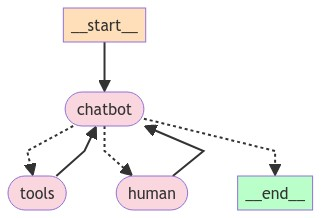

In [25]:
from IPython.display import Image, display

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

The chat bot can either request help from a human (`chatbot`$\dashrightarrow$ `human`), invoke the web search tool (`chatbot` $\dashrightarrow$`tools`), or directly respond (`chatbot`$\dashrightarrow$`__end__`). After the tool has been used or request has been made, the graph will transition back to the `chatbot` node to continue operations.

Let's see this graph in action. We will request for expert assistance to illustrate our graph.

In [26]:
user_input = (
    "I need some expert guidance for "
    "building this AI agent. Could you "
    "request assistance for me?"
)
config = {
    "configurable": {"thread_id": "1"}
}

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    input={
        "messages": [
            ("user", user_input)
        ]
    }, 
    config=config, 
    stream_mode="values"
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building this AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  RequestAssistance (1cad90f9-3a08-4666-b3fc-bb671a313e7d)
 Call ID: 1cad90f9-3a08-4666-b3fc-bb671a313e7d
  Args:
    request: I need some expert guidance for building this AI agent.


**Notice:** the LLM has invoked the `RequestAssistance` tool we provided it, and the interrupt has been set. Let's inspect the graph state to confirm.

In [28]:
snapshot = graph.get_state(config)
snapshot.next

('human',)

The graph state is indeed **interrupted** before the 
`'human'` node. We can act as the "expert" in this 
scenario and manually update the state by adding a 
new `ToolMessage` with our input.

Next, respond to the chatbot's request by:
1. Creating a `ToolMessage` with our response.
   This will be passed back to the `chatbot`.
2. Calling `update_state` to manually update the graph state.

In [31]:
ai_message = snapshot.values["messages"][-1]
human_response = (
    "We, the experts are here to help! "
    "We'd recommend you check out LangGraph "
    "to build your agent. It's much more "
    "reliable and extensible than simple "
    "autonomous agents."
)

tool_message = create_response(
    response=human_response, 
    ai_message=ai_message
)

graph.update_state(
    config=config, 
    values={
        "messages": [tool_message]
    }
)

{'configurable': {'thread_id': '1',
  'thread_ts': '1ef33890-ff09-65da-8002-af38d6e5859a'}}

You can inspect the state to confirm our response was added.

In [34]:
pprint(
    graph.get_state(config).values["messages"]
)

[HumanMessage(content='I need some expert guidance for building this AI agent. Could you request assistance for me?', id='2baedb85-82f9-4b44-b8e6-b298d97bb70d'),
 AIMessage(content='', additional_kwargs={'function_call': {'name': 'RequestAssistance', 'arguments': '{"request": "I need some expert guidance for building this AI agent."}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-419d983e-b78e-49ac-8034-5a5b7e12ca9b-0', tool_calls=[{'name': 'RequestAssistance', 'args': {'request': 'I need some expert guidance for building this AI a

Next, **resume** the graph by invoking it with `None` as the inputs.

In [35]:
events = graph.stream(
    input=None, 
    config=config, 
    stream_mode="values"
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

Okay, I've requested assistance from an expert. They recommend you check out LangGraph to build your AI agent. It's apparently more reliable and extensible than simple autonomous agents.


**Notice** that the chat bot has incorporated the updated state in its final response. Since **everything** was checkpointed, the "expert" human in the loop could perform the update at any time without impacting the graph's execution.

**Congratulations!** We've now added an additional node to your assistant graph to let the chat bot decide for itself whether or not it needs to interrupt execution. We did so by updating the graph `State` with a new `ask_human` field and modifying the interruption logic when compiling the graph. This lets us dynamically include a human in the loop while maintaining full **memory** every time we execute the graph.

## Part 7: Time Travel

In a typical chatbot workflow, the user interacts with the bot one or more times to accomplish a task. In the previous sections, we saw how to add memory and a human-in-the-loop to be able to checkpoint our graph state and manually override the state to control future responses.

But what if we want to let our user start from a previous response and "branch off" to explore a separate outcome? Or what if we want users to be able to "rewind" our assistant's work to fix some mistakes or try a different strategy (common in applications like autonomous software engineers)?

We can create both of these experiences and more using LangGraph's built-in "time travel" functionality. 

In this section, we will "rewind" our graph by fetching a checkpoint using the graph's `get_state_history` method. We can then resume execution at this previous point in time.

First, recall our chatbot graph. We don't need to make **any** changes from before:

In [44]:
from typing import Annotated, Literal

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage, BaseMessage, ToolMessage
from langchain_core.pydantic_v1 import BaseModel
from typing_extensions import TypedDict

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    ask_human: bool # This flag is new


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. 
    Use this if you are unable to assist directly 
    or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' 
    so the expert can provide the right guidance.
    """
    
    request: str


web_search_tool = TavilySearchResults(max_results=2)
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

# We can bind the llm to a tool definition, 
# a pydantic model, or a json schema
llm_with_tools = llm.bind_tools([
    web_search_tool, 
    RequestAssistance
])


def chatbot(state: State):
    response = llm_with_tools.invoke(
        state["messages"]
    )
    
    ask_human = False
    if (
        response.tool_calls and 
        response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
        
    return {
        "messages": [response], 
        "ask_human": ask_human
    }


graph_builder = StateGraph(state_schema=State)

graph_builder.add_node(
    node="chatbot", 
    action=chatbot
)

graph_builder.add_node(
    node="tools", 
    action=ToolNode(
        tools=[web_search_tool]
    )
)


def create_response(
    response: str, 
    ai_message: AIMessage
):
    """
    Creates a `ToolMessage` response with custom content.

    Parameters:
        response (str): Content of the tool message.
        ai_message (AIMessage): AI message that made the tool call.
        
    Returns:
        response (ToolMessage): Tool message with given `response`.
    """
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state 
        # during the interrupt.
        # If they choose not to, we will include a 
        # placeholder `ToolMessage` to let the LLM continue.
        new_messages.append(
            create_response(
                response="No response from human.", 
                ai_message=state["messages"][-1]
            )
        )
        
    return {
        # Append the new messages
        "messages": new_messages,
        
        # Unset the flag
        "ask_human": False,
    }
    

graph_builder.add_node(
    node="human", 
    action=human_node
)

def select_next_node(
    state: State
) -> Literal["human", "tools", "__end__"]:
    if state["ask_human"]:
        return "human"
        
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    source="chatbot",
    path=select_next_node,
)

# The rest is the same
graph_builder.add_edge(
    start_key="tools", 
    end_key="chatbot"
)

graph_builder.add_edge(
    start_key="human", 
    end_key="chatbot"
)

graph_builder.set_entry_point(
    key="chatbot"
)

memory = SqliteSaver.from_conn_string(":memory:")
graph = graph_builder.compile(
    checkpointer=memory,
    
    # Interrupt before 'human' here instead.
    interrupt_before=["human"],
)

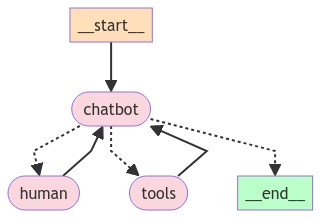

In [45]:
from IPython.display import Image, display

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

Let's have our graph take a couple steps. Every step will be checkpointed in its state history:

In [46]:
config = {
    "configurable": {"thread_id": "1"}
}

events = graph.stream(
    input={
        "messages": [
            ("user", 
             "What are some popular tourist "
             "attractions in Malaysia?")
        ]
    },
    config=config,
    stream_mode="values",
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

What are some popular tourist attractions in Malaysia?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (815e65f1-7560-4562-8bd4-5d8c9649771b)
 Call ID: 815e65f1-7560-4562-8bd4-5d8c9649771b
  Args:
    query: popular tourist attractions in Malaysia
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.tripadvisor.in/Attractions-g293951-Activities-Malaysia.html", "content": "3. Royal Selangor Visitor Centre. 3,264. Visitor Centres. Royal Selangor Visitor Centre is the go-to place in Kuala Lumpur, Malaysia to experience pewter, both as a beautiful piece to be admired and as a craft. Wander through intriguing museum exhibits and\u2026. See ways to experience (280) 2023. 4."}, {"url": "https://www.planetware.com/malaysia/top-rated-tourist-attractions-in-ma

In [47]:
events = graph.stream(
    input={
        "messages": [
            ("user", 
             "I am interested to know more "
             "about Cameron Highlands.")
        ]
    },
    config=config,
    stream_mode="values",
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I am interested to know more about Cameron Highlands.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (c45a6fc0-28cb-425c-adf4-0132615bfe04)
 Call ID: c45a6fc0-28cb-425c-adf4-0132615bfe04
  Args:
    query: Cameron Highlands
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://diveintomalaysia.com/things-to-do-in-cameron-highlands/", "content": "Discover the lush landscapes, tea plantations, hiking trails and colonial nostalgia of Cameron Highlands, a cool hill station in Malaysia. Find out the best places to visit, activities to enjoy, and tips for your trip in this comprehensive guide."}, {"url": "https://www.lonelyplanet.com/articles/how-to-plan-a-trip-to-malaysias-cameron-highlands", "content": "Learn about the history, attractions, hiking trails, an

Now that we've had the agent take a couple steps, we can `replay` the full state history to see everything that occurred.

In [48]:
to_replay = None

for state in graph.get_state_history(config):
    print(
        "Num Messages:", 
        len(state.values["messages"])        
    )
    print("Next:", state.next)
    print("-" * 80)
    
    if len(state.values["messages"]) == 6:
        # We are somewhat arbitrarily selecting a 
        # specific state based on the number of chat 
        # messages in the state.
        to_replay = state

Num Messages: 8
Next: ()
--------------------------------------------------------------------------------
Num Messages: 7
Next: ('chatbot',)
--------------------------------------------------------------------------------
Num Messages: 6
Next: ('tools',)
--------------------------------------------------------------------------------
Num Messages: 5
Next: ('chatbot',)
--------------------------------------------------------------------------------
Num Messages: 4
Next: ('__start__',)
--------------------------------------------------------------------------------
Num Messages: 4
Next: ()
--------------------------------------------------------------------------------
Num Messages: 3
Next: ('chatbot',)
--------------------------------------------------------------------------------
Num Messages: 2
Next: ('tools',)
--------------------------------------------------------------------------------
Num Messages: 1
Next: ('chatbot',)
-----------------------------------------------------------

**Notice** that checkpoints are saved for every step of the graph. This __spans invocations__ so you can rewind across a full thread's history. We've picked out `to_replay` as a state to resume from. This is the state after the `chatbot` node in the second graph invocation above.

Resuming from this point should call the **`tools`** node next.

In [49]:
print(to_replay.next)
print(to_replay.config)

('tools',)
{'configurable': {'thread_id': '1', 'thread_ts': '1ef33956-2fd2-61d8-8006-36762b3022ab'}}


**Notice** that the checkpoint's config (`to_replay.config`) contains a `thread_ts` **timestamp**. Providing this `thread_ts` value tells LangGraph's checkpointer to **load** the state from that moment in time. Let's try it below:

In [50]:
events = graph.stream(
    input=None, 
    
    # The `thread_ts` in the `to_replay.config` corresponds 
    # to a state we've persisted to our checkpointer.
    config=to_replay.config, 
    
    stream_mode="values"
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://diveintomalaysia.com/things-to-do-in-cameron-highlands/", "content": "Discover the lush landscapes, tea plantations, hiking trails and colonial nostalgia of Cameron Highlands, a cool hill station in Malaysia. Find out the best places to visit, activities to enjoy, and tips for your trip in this comprehensive guide."}, {"url": "https://www.lonelyplanet.com/articles/how-to-plan-a-trip-to-malaysias-cameron-highlands", "content": "Learn about the history, attractions, hiking trails, and culture of Malaysia's Cameron Highlands, a hilly region with mild climate and scenic views. Find tips on where to stay, what to eat, and how to avoid tourism pitfalls."}]
================================== Ai Message ==================================

Cameron Highlands is a popular hill station in Malaysia known for its lush landscapes, tea plantations, hiking trails, and col

Notice that the graph resumed execution from the **`tools`** node. The first value printed above is the response from the web search tool.

**Congratulations!** We've now used time-travel checkpoint traversal in LangGraph. Being able to rewind and explore alternative paths opens up a world of possibilities for debugging, experimentation, and interactive applications.

## Conclusion

Congrats! We've built a chatbot in LangGraph that supports tool calling, persistent memory, human-in-the-loop interactivity, and even time-travel!

You can learn more about LangGraph by going through some more guided examples:
[LangGraph Tutorials](https://langchain-ai.github.io/langgraph/tutorials/)
